### Init

In [1]:
import os
from pathlib import Path
import yaml
from PIL import Image

import sys 
sys.path.append('..')

import torch
from datasets import load_dataset

from segment.grounded_sam import run_grounded_sam_batch
from segment.grounded_sam import transform_image_dino
from segment.grounded_sam import transform_image_sam
from segment.utils import resize_preserve_aspect_ratio
from segment.utils import convert_coco_polygons_to_mask
from segment.utils import overlay_mask
from segment.utils import get_coco_style_polygons
from segment.utils import pad_to_fixed_size
from segment.utils import unload_box
from segment.utils import unload_mask
from segment.utils import get_device
from segment.utils import resize_image_pil

from segment.sam_results import SAMResults

final text_encoder_type: bert-base-uncased
_IncompatibleKeys(missing_keys=[], unexpected_keys=['label_enc.weight', 'bert.embeddings.position_ids'])


### This is for testing the grounded_sam.py file

### Load

In [10]:
def load_yaml(path):
    with open(path, "r") as file:
        data = yaml.load(file, Loader=yaml.FullLoader)
    return data


def get_labels_dict(yolo_config):
    data = load_yaml(yolo_config)
    labels_dict = data.get("names")
    labels_dict = {v: k for k, v in labels_dict.items()}
    return labels_dict

CACHE_DIR = os.path.join(os.getcwd(),'..','hf_cache')

# Yolo Config File With Labels
YOLO_CONFIG = os.path.join(os.getcwd(),'..',"configs/fashion_people_detection.yml")

data = load_yaml(YOLO_CONFIG)
labels_dict = get_labels_dict(YOLO_CONFIG)

# Repo For Dataset
repo_id = "jordandavis/fashion_people_detections"

# Workers & Device
workers = os.cpu_count()
device = get_device()

In [26]:
# Load Dataset
ds = load_dataset(
    repo_id,
    split="train",
    streaming=False,
    trust_remote_code=True,
    cache_dir=CACHE_DIR,
    num_proc=workers
)

Resolving data files:   0%|          | 0/20 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/20 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/24 [00:00<?, ?it/s]

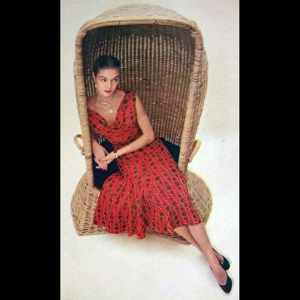

In [77]:
def load_image(image_path):
    image_pil = Image.open(image_path).convert("RGB")
    image_pil = resize_image_pil(image_pil, 1024)
    return image_pil

image_dir = Path('../datasets/fashion_people_detection/images/val')
image_paths = list(image_dir.glob('*.jpg'))

images = [load_image(path) for path in image_paths[:4]]

image_num = 0
images[image_num].resize((300,300))

### Use

In [89]:
dino_images = torch.stack([transform_image_dino(image) for image in images])
sam_images = torch.stack([transform_image_sam(image) for image in images])

dino_images = dino_images.to(device)
sam_images = sam_images.to(device)

In [90]:
labels_dict = get_labels_dict(YOLO_CONFIG)
labels = [k for k in labels_dict.keys()]
text_prompt = " . ".join(labels)

In [116]:
text_prompt = 'legs'
labels_dict = {"legs":1}

In [117]:
unformatted_results = run_grounded_sam_batch(dino_images, sam_images, text_prompt)

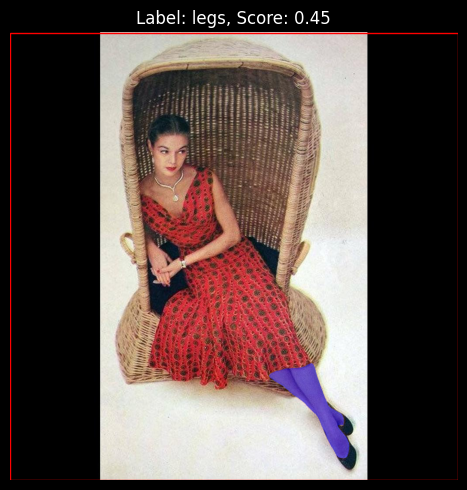

In [118]:
r = SAMResults(
    images[image_num],
    labels_dict,
    **unformatted_results[image_num],
    person_masks_only=False
)
r.display_results()

In [119]:
def get_masks_md(results):
    results_list = []
    for result in results.formatted_results:
        mask = result.get("mask")
        coco_polygons = get_coco_style_polygons(mask)

        # format the polygons
        result.update({"polygons": coco_polygons})
        result.pop("mask")
        results_list.append(result)
    return results_list

In [120]:
unformatted_results[0]

{'masks': tensor([[[[False, False, False,  ..., False, False, False],
           [False, False, False,  ..., False, False, False],
           [False, False, False,  ..., False, False, False],
           ...,
           [False, False, False,  ..., False, False, False],
           [False, False, False,  ..., False, False, False],
           [False, False, False,  ..., False, False, False]]]], device='cuda:0'),
 'boxes': tensor([[ 591.6730,  753.7522,  793.6192, 1001.7122]]),
 'scores': tensor([0.4525]),
 'phrases': ['legs']}

In [121]:
masks_md = []
image_ids = [0,1]
for image_id, image, raw_result in zip(image_ids, images, unformatted_results):
    # if raw_result.get('masks') is None or ('person' not in raw_result.get("phrases")):
    #     # mask_md_row = dict(zip(str(image_id), [None]))
    #     mask_md = None
    # else:
    result = SAMResults(image, labels_dict, **raw_result, person_masks_only=False)
    mask_md = get_masks_md(result)

    # mask_metadata.update(mask_md_row)
    masks_md.append(mask_md)

In [122]:
polygons = masks_md[1][0]['polygons']
label = masks_md[1][0]['label']
image = images[1]
print(label)
mask = convert_coco_polygons_to_mask(polygons, 1024, 1024)

legs


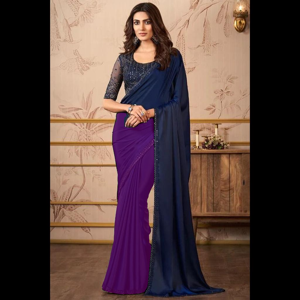

In [123]:
mask_image = Image.fromarray(mask)
overlay_mask(image, mask_image).resize((300,300))

hair


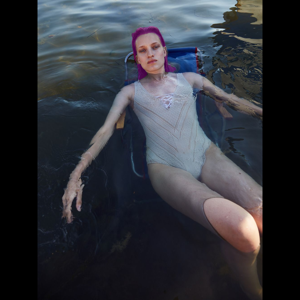

In [124]:
row = 102
mask_row = 2
ds_polygons = ds[row]['mask_metadata'][mask_row]['polygons']
ds_label = ds[row]["mask_metadata"][mask_row]["label"]
image = ds[row]["image"]
image = resize_image_pil(image, 1024)   

print(ds_label)

mask = convert_coco_polygons_to_mask(ds_polygons, image.height, image.width)
mask_image = Image.fromarray(mask)
overlay_mask(image, mask_image).resize((300,300))